In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from Backtesting import stats, portfolio

In [2]:
def signal_generation(asset, window1, window2):

    signals = pd.DataFrame()
    signals['asset'] = asset['Close']
    signals['ma1'] = 0
    signals['ma2'] = 0
    signals['signals'] = 0
    signals['ma1'] = ((asset['High'] + asset['Low'])/2).rolling(window=min(window1, window2)).mean()
    signals['ma2'] = ((asset['High'] + asset['Low'])/2).rolling(window=max(window1, window2)).mean()
    signals['oscillator'] = signals['ma1'] - signals['ma2']  
    signals['positions'] = 0

    for i in range(2, len(signals)):

        # Detecting bearish & bullish saucers in oscillator

        if asset['Open'].iloc[i] > asset['Close'].iloc[i] and asset['Open'].iloc[i-1] < asset['Close'].iloc[i-1] and asset['Open'].iloc[i-2] < asset['Close'].iloc[i-2]:
            if signals['oscillator'].iloc[i-1] > signals['oscillator'].iloc[i-2] and signals['oscillator'].iloc[i-1] < 0 and signals['oscillator'].iloc[i] < 0:
                signals.at[signals.index[i],'signals'] = 1

        if asset['Open'].iloc[i] < asset['Close'].iloc[i] and asset['Open'].iloc[i-1] > asset['Close'].iloc[i-1] and asset['Open'].iloc[i-2] > asset['Close'].iloc[i-2]:
            if signals['oscillator'].iloc[i-1] < signals['oscillator'].iloc[i-2] and signals['oscillator'].iloc[i-1] > 0 and signals['oscillator'].iloc[i] > 0:
                signals.at[signals.index[i],'signals'] = -1

        # Avoid signals likely to generate less profit than pre-existing positions

        if signals['ma1'].iloc[i] > signals['ma2'].iloc[i]:
            signals.at[signals.index[i], 'signals'] = 1
            signals['positions'] = signals['signals'].cumsum()
            if signals['positions'].iloc[i] > 1:
                signals.at[signals.index[i], 'signals'] = 0

        if signals['ma1'].iloc[i] < signals['ma2'].iloc[i]:
            signals.at[signals.index[i], 'signals'] = -1
            signals['positions'] = signals['signals'].cumsum()
            if signals['positions'].iloc[i] < 0:
                signals.at[signals.index[i], 'signals'] = 0

    signals['positions'] = signals['signals'].cumsum()

    return signals

In [3]:
def plot(signals, ticker):
    
    # Long/short signals
    plt.figure(figsize=(11,7))
    plt.plot(signals['asset'], label=ticker, alpha=0.8, color='C0')
    plt.plot(signals['asset'][signals['signals']>0], lw=0, marker='^', markersize=7, c='g', alpha=0.6, label='LONG')
    plt.plot(signals['asset'][signals['signals']<0], lw=0, marker='v', markersize=7, c='r', alpha=0.6, label='SHORT')
    plt.legend(loc='upper left')
    plt.xlabel('Date', labelpad=15)
    plt.ylabel(ticker, labelpad=15)
    plt.title('Awesome', pad=15)
    plt.grid(True)
    plt.show()
    
    # Running oscillator
    fig=plt.figure(figsize=(11,7))
    ax=fig.add_subplot(111)
    ax2=ax.twinx()
    ax.plot(signals['ma1'], color='C0', alpha=0.8, label='Short Term')
    ax.plot(signals['ma2'], color='C1', alpha=0.8, label='Long Term')
    ax2.bar(signals.index, signals['oscillator'], color='r', alpha=0.2, label='Oscillator')
    ax.set_ylabel("Moving Average", labelpad=15)
    ax2.set_ylabel("Difference", rotation=270, labelpad=15)
    ax.set_xlabel('Date', labelpad=15)
    plt.legend(loc='upper left')
    plt.grid(True)
    plt.title('Awesome', pad=15)
    plt.show()

In [4]:
def Awesome(ticker, start_date, end_date, capital):

    asset = yf.download(ticker, start=start_date, end=end_date, progress=False)
    
    # Default windows of 5 and 34 days
    signals = signal_generation(asset, 5, 34)
    
    plot(signals, ticker)

    return stats(portfolio(signals, capital, 'Awesome'), signals, start_date, end_date, capital)

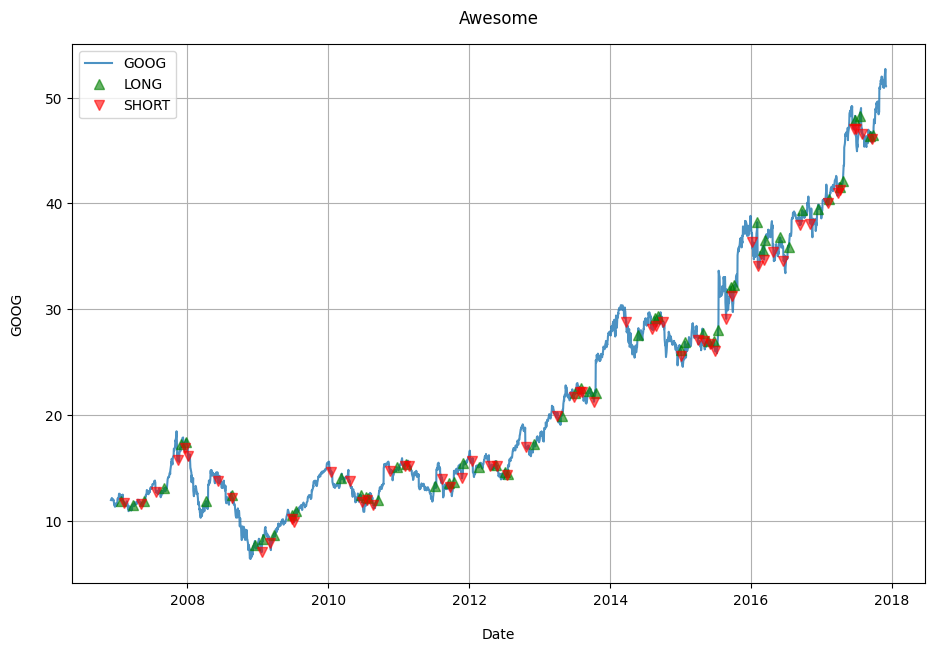

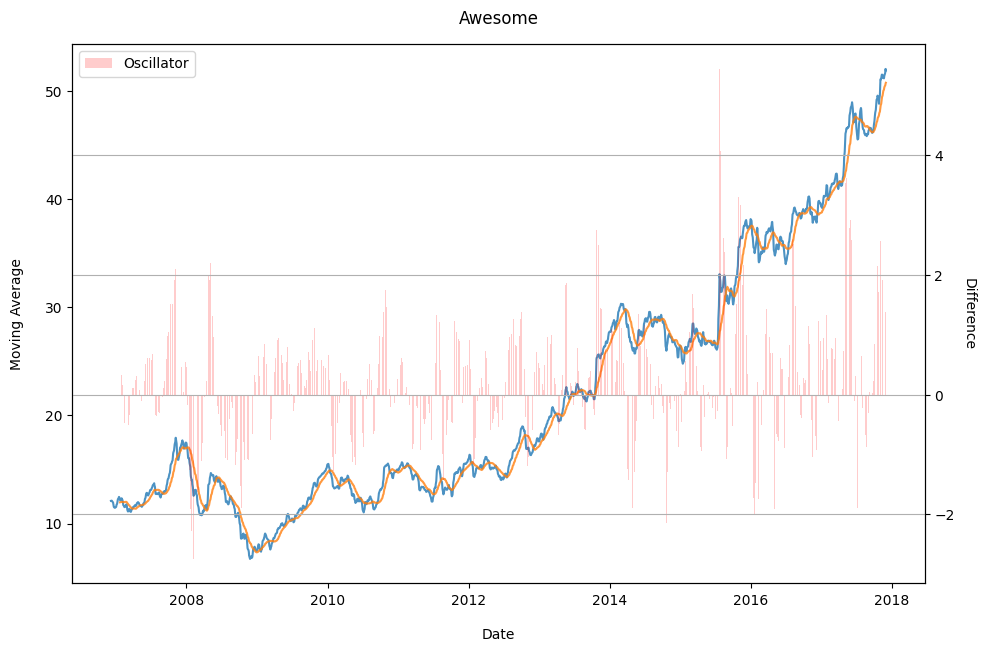

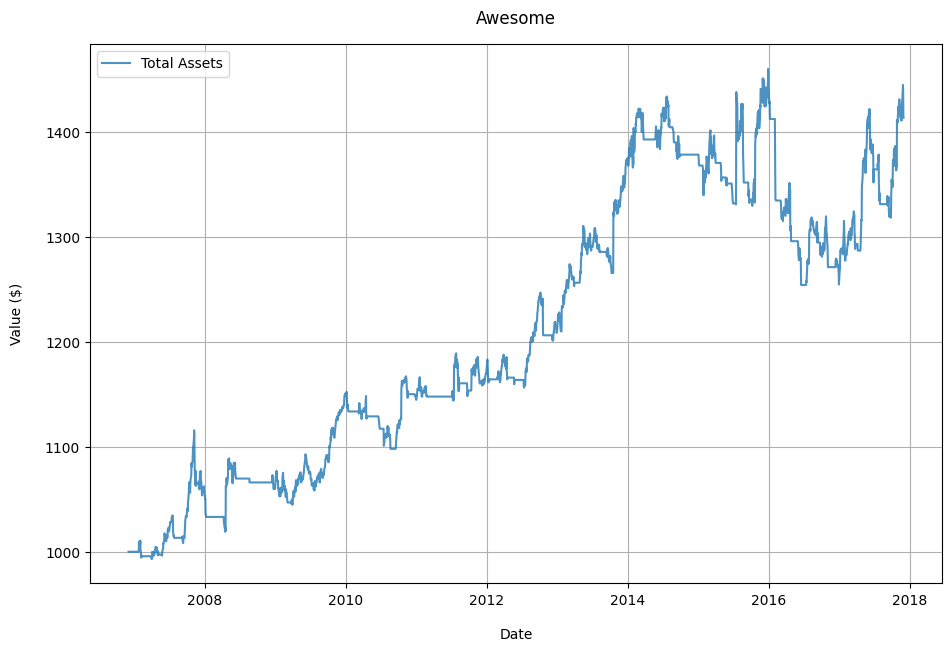

,portfolio return,benchmark return,growth rate,sharpe ratio,maximum drawdown,calmar ratio,avg trade length,profit per trade
0,0.41345,0.890278,0.000125,-0.025785,-0.140955,-0.000887,13.700855,3.533763


In [5]:
Awesome('GOOG', '2006-12-01', '2017-12-01', 1000)